# Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import fbeta_score, make_scorer
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 16, 6

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<div class="alert alert-block alert-info">Вывод</div>  

Даны заказы такси с интервалом 10 минут с 2018-03-01 00:00:00 по 2018-08-31 23:50:00, пропусков нет, стандартное отклонение 45.  
Всего один признак: колличество заказов. Необходимо создать признаки календарные, скользящие и отстающие значения.

## Анализ

Проведем ресемплирование и отобразим граффик

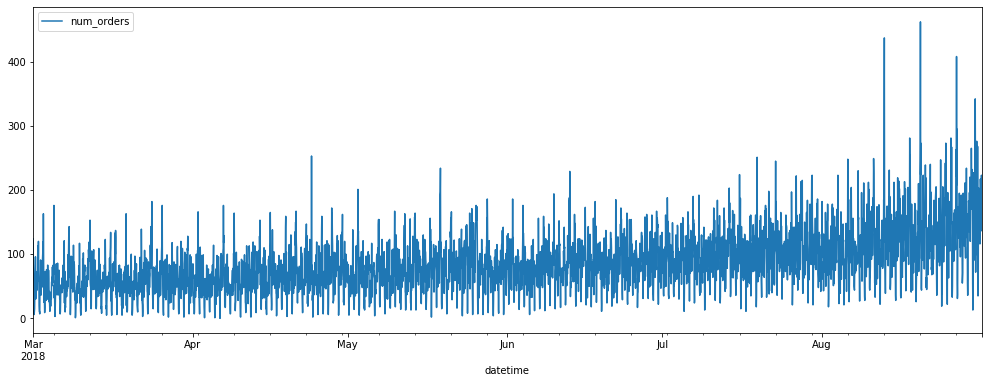

In [ ]:
data = data.resample('1H').sum()
figsize = (17, 6)
data.plot(figsize=figsize)

Разложим временной ряд на три составляющие: тренд, сезонность и остаток 

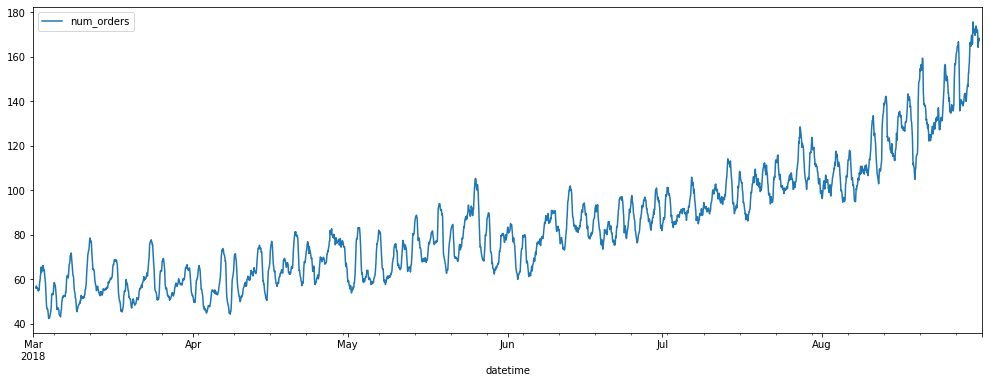

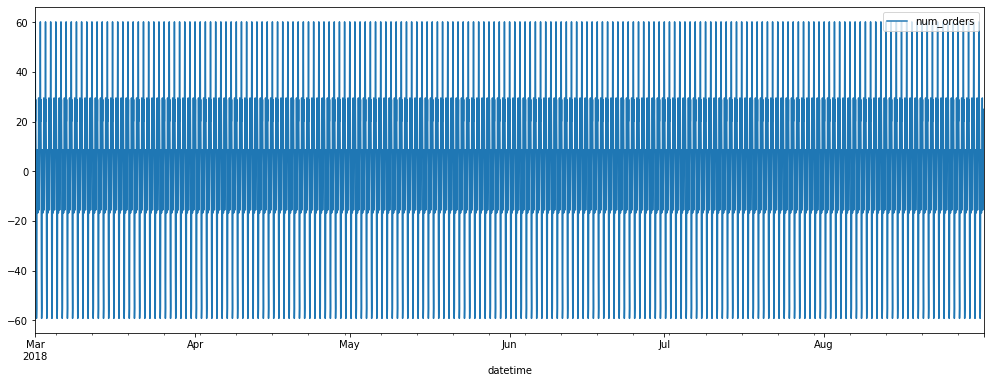

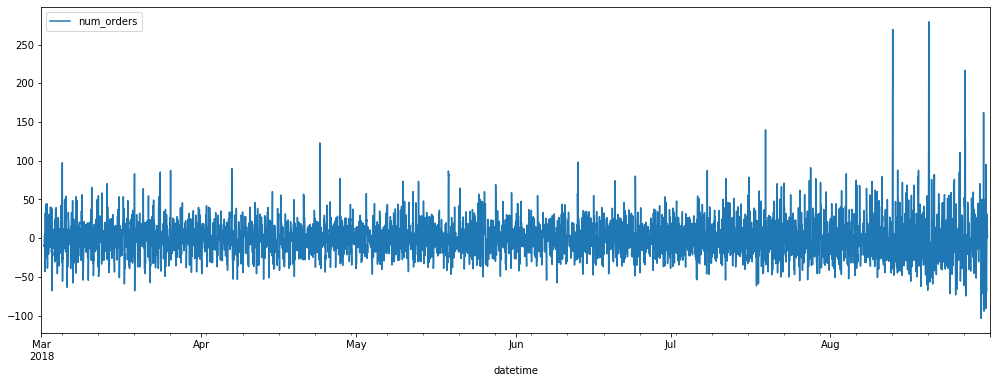

In [ ]:
decomposed_data = seasonal_decompose(data)
decomposed_data.trend.plot(figsize=figsize)
decomposed_data.seasonal.plot(figsize=figsize)
decomposed_data.resid.plot(figsize=figsize)

Разложим последнюю неделю на три составляющие: тренд, сезонность и остаток 

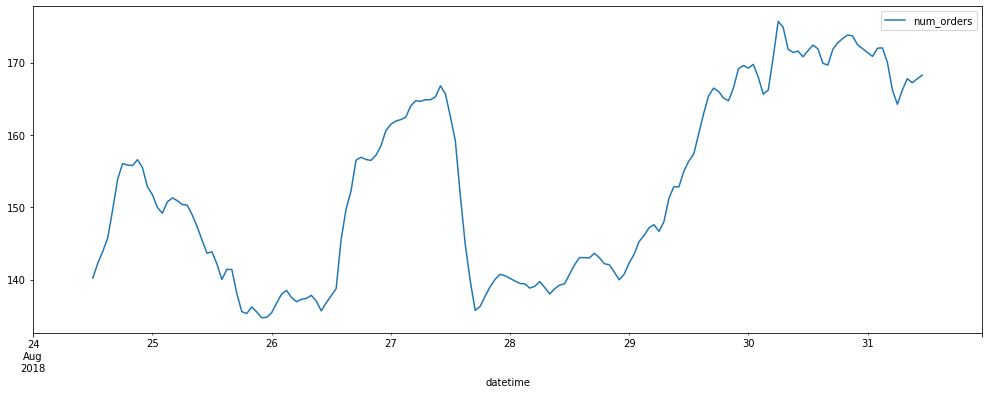

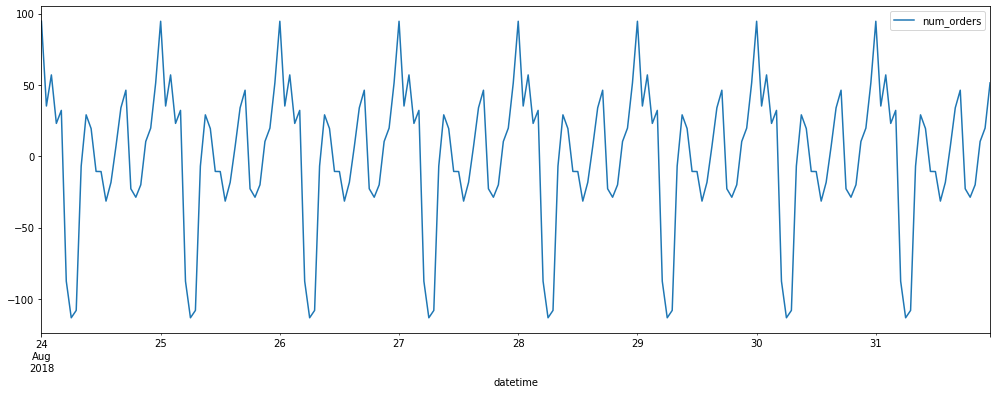

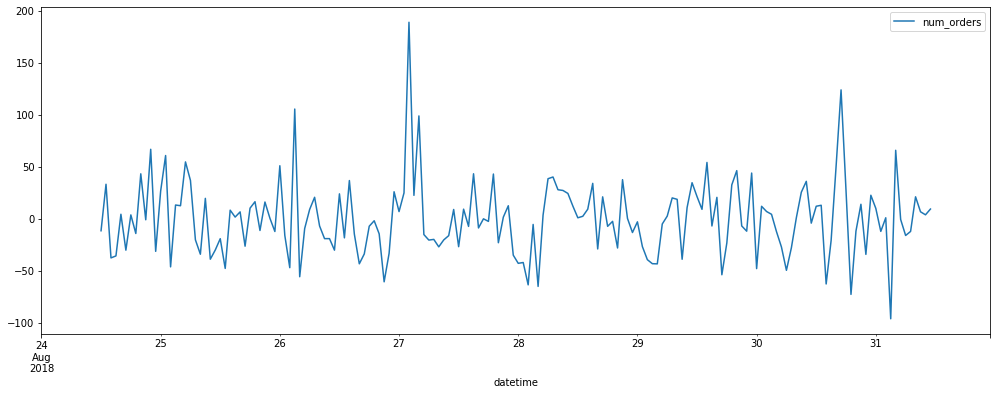

In [ ]:
decomposed_data = seasonal_decompose(data['2018-08-24':'2018-08-31'])
decomposed_data.trend.plot(figsize=figsize)
decomposed_data.seasonal.plot(figsize=figsize)
decomposed_data.resid.plot(figsize=figsize)

**Вывод**
- Дисперсия ряда всего датасета со временем увеличивается, временной ряд не является стационарным, так как подвержен тренду,
- 
- По тренду видно, что со временем все больше и больше людей пользуется услугой заказа такси.
- Спрос высокий в понедельник и увеличивается со среды по пятницу, выходные дни менее активны.
- При разложении по последней неделе видно, что имеются пиковые часы и больше всего такси используется в ночное время и дальше спрос максимально спадает под утро. 

Создам функцию make_features которая:  
Добавляет фактор месяца и фактор дня исходя из общего тренда  
Добавляет фактор дня недели, так как на графике недели видим большую вариацию
Добавляет фактор часа, так как прослеживаем пики активности в течении суток
Добавляет lag  
Добавляет rolling просто переберу

In [ ]:
def make_features(df, max_lag, rolling_sum_size):
    mf_df = data.copy(deep=True)
    mf_df['month'] = df.index.month
    mf_df['day'] = df.index.day
    mf_df['dayofweek'] = df.index.dayofweek
    mf_df['hour'] = df.index.hour
    for lag in range(1, max_lag + 1):
        mf_df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    mf_df['rolling_sum'] = df['num_orders'].shift().rolling(rolling_sum_size).mean()
    return mf_df

Добавлю функциб для вычесления rmse

In [ ]:
def rmse(first_list, second_list):
    return np.sqrt(mean_squared_error(first_list, second_list))

## Обучение

### Линейная регрессия

Для определения количество lag признаков найдем разницу в часах между максимальным пиком и минимальным уровнем в течении 24 часов  

In [ ]:
day_data = seasonal_decompose(data['2018-08-30':'2018-08-31'])
max_lag = ((day_data.seasonal.idxmax() - day_data.seasonal.idxmin()) 
            #// np.timedelta64(1, 'h'))[0]
max_lag

Фактор rolling

In [ ]:
best_rmse = 99999999
for log in range(47, 50):
    for rsz in range(2, 5):
        find_data = make_features(data, log, rsz)

        data_lr, test = train_test_split(find_data, shuffle=False, test_size=0.1)
        train, valid = train_test_split(data_lr, shuffle=False, test_size=0.25)
        train = train.dropna()
        features_train = train.drop("num_orders", axis=1)
        target_train = train["num_orders"]

        features_valid = valid.drop("num_orders", axis=1)
        target_valid = valid["num_orders"]

        lin_reg = LinearRegression()
        lin_reg.fit(features_train, target_train)

        preds = lin_reg.predict(features_valid)

        current_rmse = rmse(preds, target_valid)
        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_rsz = rsz
            best_log = log
print("RMSE:", best_rmse, "\nrolling_sum:", best_rsz, "\nlog:", best_log)


RMSE: 29.47742524371078 
rolling_sum: 3 
log: 48


In [ ]:
data_lr = make_features(data, 48, 3) 

train, test = train_test_split(data_lr, shuffle=False, test_size=0.1)
train.dropna(inplace=True)
test.dropna(inplace=True)

features_train = train.drop("num_orders", axis=1)
target_train = train["num_orders"]

features_test = test.drop("num_orders", axis=1)
target_test = test["num_orders"]

In [ ]:
target_train

datetime
2018-03-03 00:00:00    163
2018-03-03 01:00:00    108
2018-03-03 02:00:00     25
2018-03-03 03:00:00     64
2018-03-03 04:00:00     44
                      ... 
2018-08-13 09:00:00    137
2018-08-13 10:00:00    156
2018-08-13 11:00:00    144
2018-08-13 12:00:00     92
2018-08-13 13:00:00    119
Freq: H, Name: num_orders, Length: 3926, dtype: int64

### Cat Boost

In [ ]:
modelCat = CatBoostRegressor( random_state = 12345)
hyperparams = [{'depth' : [3], #брал 1, 2, 3
                'learning_rate' : [0.1], #брал 0.03, 0.06, 0.1
                'iterations' : [300], #брал 100, 200, 300
                'verbose' : [False]
               }]
my_cv=TimeSeriesSplit(n_splits=3).split(features_train)
clf = GridSearchCV(modelCat, hyperparams, cv=my_cv, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
best_params_CBR = clf.best_params_
print(best_params_CBR)
print((clf.best_score_*-1)**0.5)


{'depth': 3, 'iterations': 300, 'learning_rate': 0.1, 'verbose': False}
25.407826073591742


### LGBMRegressor

In [ ]:
LGBMR = LGBMRegressor() 
hyperparams = [{'depth' : [3],
                'learning_rate':[0.03],
                'verbose' : [10],
                'random_state':[12345]}]

my_cv=TimeSeriesSplit(n_splits=3).split(features_train)
clf = GridSearchCV(modelCat, hyperparams, cv=my_cv, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)


0:	learn: 28.8728318	total: 1.28ms	remaining: 1.28s
10:	learn: 25.8129859	total: 58.2ms	remaining: 5.23s
20:	learn: 23.7287482	total: 69.7ms	remaining: 3.25s
30:	learn: 22.1640731	total: 163ms	remaining: 5.08s
40:	learn: 21.0147143	total: 260ms	remaining: 6.09s
50:	learn: 20.1716535	total: 357ms	remaining: 6.64s
60:	learn: 19.5652382	total: 446ms	remaining: 6.87s
70:	learn: 19.1107808	total: 543ms	remaining: 7.1s
80:	learn: 18.7167504	total: 637ms	remaining: 7.23s
90:	learn: 18.4109963	total: 730ms	remaining: 7.29s
100:	learn: 18.1157437	total: 825ms	remaining: 7.34s
110:	learn: 17.8722793	total: 921ms	remaining: 7.38s
120:	learn: 17.6293494	total: 931ms	remaining: 6.77s
130:	learn: 17.4666826	total: 1.03s	remaining: 6.81s
140:	learn: 17.2895792	total: 1.12s	remaining: 6.83s
150:	learn: 17.1252424	total: 1.21s	remaining: 6.82s
160:	learn: 17.0152432	total: 1.31s	remaining: 6.83s
170:	learn: 16.8856965	total: 1.4s	remaining: 6.81s
180:	learn: 16.7671862	total: 1.5s	remaining: 6.79s
190:

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f66c436e650>,
             error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7f66c43c8c10>,
             iid='warn', n_jobs=None,
             param_grid=[{'depth': [3], 'learning_rate': [0.03],
                          'random_state': [12345], 'verbose': [10]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [ ]:
print(clf.best_params_)
print((clf.best_score_*-1)**0.5)

{'depth': 3, 'learning_rate': 0.03, 'random_state': 12345, 'verbose': 10}
25.165085819016046


## Тестирование

### Линейная регрессия

43.13766773765936


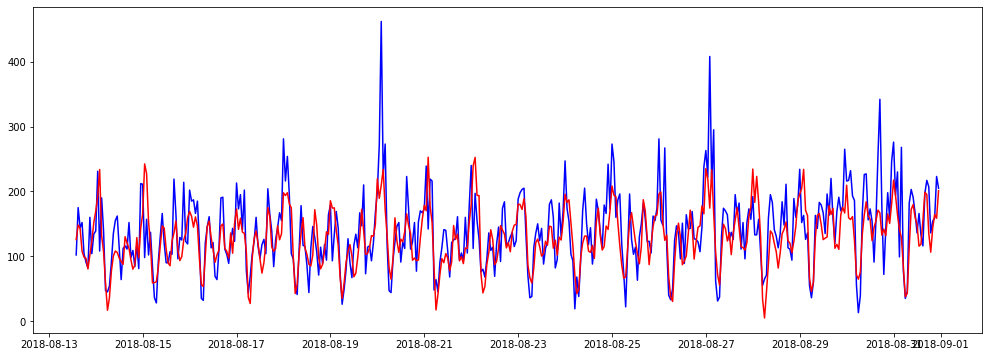

In [ ]:
model = LinearRegression()
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
rmse_lr = mean_squared_error(target_test, target_predict) ** 0.5
print(rmse_lr)
plt.figure(figsize=figsize)
plt.plot(target_test.index, target_test, 'b-', target_test.index, target_predict,'r-')

### Cat Boost

40.13368287135588


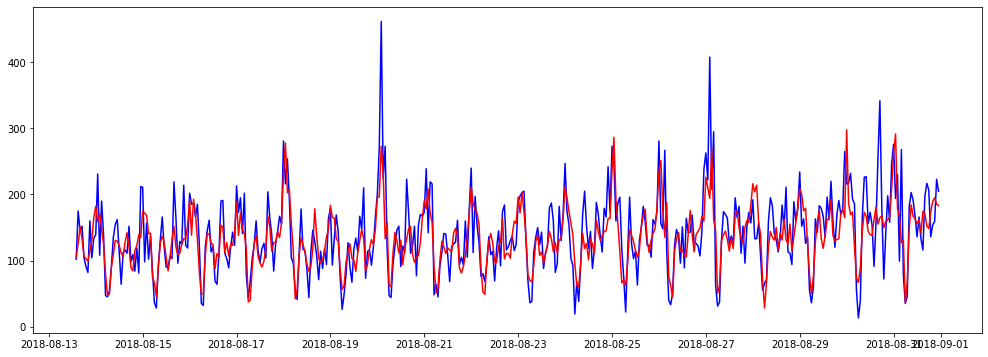

In [ ]:
modelCat = CatBoostRegressor(depth = 3, iterations = 300, learning_rate = 0.1, verbose= False)
modelCat.fit(features_train, target_train)
modelCat_predict = modelCat.predict(features_test)
rmse_cbr = mean_squared_error(target_test, modelCat_predict) ** 0.5
print(rmse_cbr)
plt.figure(figsize=figsize)
plt.plot(target_test.index, target_test, 'b-', target_test.index, modelCat_predict,'r-')

### LGBMRegressor

41.87516856834302


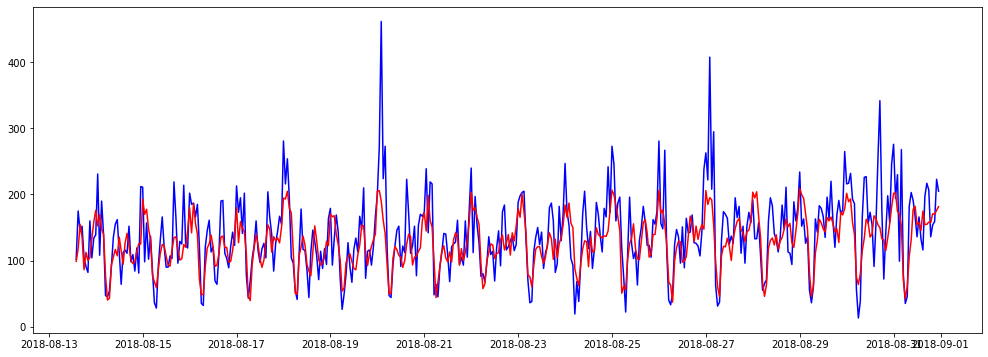

In [ ]:
LGBMR = LGBMRegressor(depth = 3, learning_rate = 0.03, random_state = 12345, verbose = 10)
LGBMR.fit(features_train, target_train)
target_predict = LGBMR.predict(features_test)
rmse_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5
print(rmse_LGBMR)
plt.figure(figsize=figsize)
plt.plot(target_test.index, target_test, 'b-', target_test.index, target_predict,'r-')

**Вывод**  
По итогам тестирования лучше всего предсказала ряд модель Cat Boost. RMSE = 40.13. Ошибка на 40 заказов в час.  
Далее идет LGBMRegressor = 41.87  
Линейное тестирование 43.13  
Я предположу что большое количество шумов смогло негативно повлиять на регрессоры.